c:\Users\marce\OneDrive\Documents\BathLife\Y3\RL\CS1\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(4, 128, 64)
0.8878205128205129
False
False
{'speed': 25.500000000000004, 'crashed': False, 'action': [0.5, 0.0], 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 0.3333333333333333, 'high_speed_reward': np.float64(0.5500000000000004), 'on_road_reward': 1.0}}


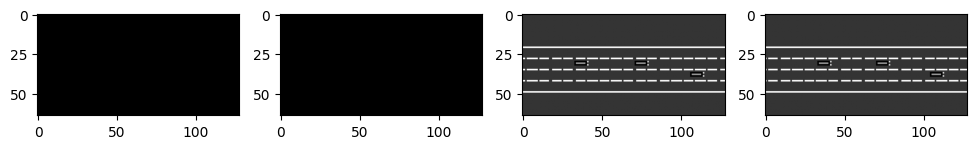

In [ ]:
import gymnasium as gym
import highway_env
import matplotlib.pyplot as plt
import torch

# Define environment configuration using images as info
config = {
    "observation": {
        "type": "GrayscaleObservation", 
        "observation_shape": (128, 64), # Image size
        "stack_size": 4,                # Number of images
        "weights": [0.2989, 0.5870, 0.1140],
        "scaling": 1.75,
    },
    "action": {                         # Define continous x and y actions
        "type": "ContinuousAction",
        "longitudinal": True,
        "lateral": True,
        
        # Original steering -> struggling to turn enough to avoid car
        # "steering_range": [-0.15, 0.15], 

        # Improved steering -> easier to overtake
        "steering_range": [-0.2, 0.2],  
        
        # Original speed range -> agent learnt that slow and no overtakes was good
        # "speed_range": [10, 30]

        # Improved speed range -> agent must learn to overtake
        "speed_range": [23, 33]
    },
    "simulation_frequency": 15, # Physics updates per second
    "policy_frequency": 5,      # Decisions per second (0.2s reaction time)
    "duration": 40, 
    "offroad_terminal": True,
    "lanes_count": 4, 
    
    # REWARD SHAPING (Encourage the behavior you want)
    "collision_reward": -2.0,
    "high_speed_reward": 0.5, # Reduced slightly since we force speed anyway
}

# Create environment and display example state input
env = gym.make('highway-fast-v0', config=config, render_mode='rgb_array')
obs, info = env.reset()
action = [0.5, 0.0] # Random action

for _ in range(1):
    obs, reward, done, truncated, info = env.step(action)

    print(f"State shape: {obs.shape}")
    print(f"Obtained reward: {reward}")
    print(f"Done status: {done}")
    print(f"Truncated status: {truncated}")
    print(f"Extra info: {info}")

    # State images
    fig, axes = plt.subplots(ncols=4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
from SAC import SAC

# Create a dummy agent
agent = SAC(env, state_size=4)

# Create a fake input batch: 32 images of size 4x128x64
fake_state = torch.randn(32, 4, 128, 64)
fake_action = torch.randn(32, 2)

# 1. Test Actor
print("Testing Actor...")
mu, log_std = agent.actor(fake_state)
print(f"Actor Output Shape: {mu.shape}") # Should be (32, 2)

# 2. Test Critic
print("Testing Critic...")
q_val = agent.critic_1(fake_state, fake_action) 
print(f"Critic Output Shape: {q_val.shape}") # Should be (32, 1)

print("Correct dimensions!")

Testing Actor...
Actor Output Shape: torch.Size([32, 2])
Testing Critic...
Critic Output Shape: torch.Size([32, 1])
Dimensions look good!


Step-milestone: 0
Step 6: Episode Reward: 5.212011387830754
Step 13: Episode Reward: 5.151763182544081
Step 16: Episode Reward: 1.7482934886208645
Step 18: Episode Reward: 0.8679819795962311
Step 38: Episode Reward: 16.311281486920933
Step 51: Episode Reward: 10.951805372747152
Step 55: Episode Reward: 2.7954155506732126
Step 68: Episode Reward: 10.459643334748023
Step 77: Episode Reward: 6.771990111347187
Step 81: Episode Reward: 2.5523365247929526
Step 89: Episode Reward: 6.145836680026569
Step 93: Episode Reward: 2.7573011274814654
Step 96: Episode Reward: 1.8393663876723163
Step 105: Episode Reward: 6.925539717804825
Step 108: Episode Reward: 1.8059201128409903
Step 111: Episode Reward: 1.8376688602433644
Step 120: Episode Reward: 6.594143948668425
Step 129: Episode Reward: 6.824071445002334
Step 133: Episode Reward: 2.588315537654672
Step 135: Episode Reward: 0.8731898313868939
Step 138: Episode Reward: 1.7100645687687757
Step 146: Episode Reward: 5.99861293498258
Step 149: Episod

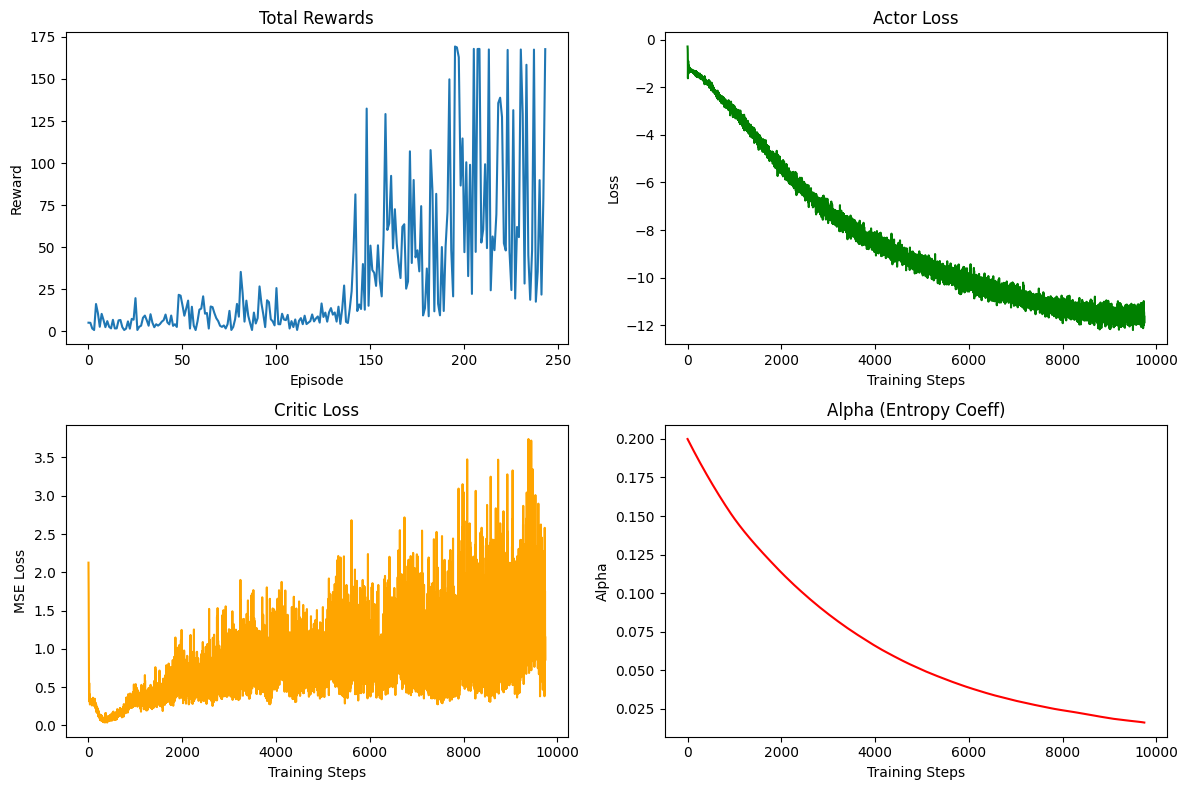

<Figure size 640x480 with 0 Axes>

In [3]:
# Main Loop Test

# 1. Train agent and collect losses and rewards over episodes 
rewards, critic_losses, actor_losses, alphas = agent.train_loop()

# 2. Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot A: Rewards (Per Episode)
axes[0,0].plot(rewards)
axes[0,0].set_title("Total Rewards")
axes[0,0].set_xlabel("Episode") 
axes[0,0].set_ylabel("Reward")

# Plot B: Critic Loss (Per Step)
axes[1,0].plot(critic_losses, color='orange')
axes[1,0].set_title("Critic Loss")
axes[1,0].set_xlabel("Training Steps")
axes[1,0].set_ylabel("MSE Loss")

# Plot C: Actor Loss (Per Step)
axes[0,1].plot(actor_losses, color='green')
axes[0,1].set_title("Actor Loss")
axes[0,1].set_xlabel("Training Steps") 
axes[0,1].set_ylabel("Loss")

# Plot D: Alpha Decay (Per Step)
axes[1,1].plot(alphas, color='red')
axes[1,1].set_title("Alpha (Entropy Coeff)")
axes[1,1].set_xlabel("Training Steps") 
axes[1,1].set_ylabel("Alpha")

plt.tight_layout()
plt.show()
plt.savefig("SAC_plots_improved.png")

In [5]:
from gymnasium.wrappers import RecordVideo

#agent.load_actor_only("best_model.pth")

# Define class to record test output runs
env = RecordVideo(
    env, 
    video_folder="videos_improved/sac_highway", 
    episode_trigger=lambda e: True, # Record every episode
    name_prefix="sac_eval"
)

print("Starting Evaluation...")
NUM_EPISODES = 5

# Evaluation loop, deterministacally stepping in our environment to test our learned actor policy
for episode in range(NUM_EPISODES):
    obs, info = env.reset()
    done = truncated = False
    score = 0
    
    while not (done or truncated):
        action = agent.choose_action_deterministic(obs)
        next_obs, reward, done, truncated, info = env.step(action)
        obs = next_obs
        score += reward
        
    print(f"Recorded Episode {episode + 1}: Score = {score:.2f}")

env.close()
print("Videos saved to 'videos_improved/sac_highway' folder.")

c:\Users\marce\OneDrive\Documents\BathLife\Y3\RL\CS1\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\marce\OneDrive\Documents\BathLife\Y3\RL\CS1\algorithms\SAC\videos_improved\sac_highway folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Starting Evaluation...
Recorded Episode 1: Score = 32.02
Recorded Episode 2: Score = 68.07
Recorded Episode 3: Score = 120.92
Recorded Episode 4: Score = 103.27
Recorded Episode 5: Score = 147.68
Videos saved to 'videos_improved/sac_highway' folder.
